# Generic examples

## Plot examples

The `plot` function is an utility function internally calling multiple `matplotlib.pyplot` functions depending on the given arguments (such as `plt.legend`, `plt.colorbar`, `plt.figure`, ...)

The `plot_multiple` allows to plot multiple data : each data is given to the `plot` function and is plotted in a different subplot (at least if `use_subplots = True`). 

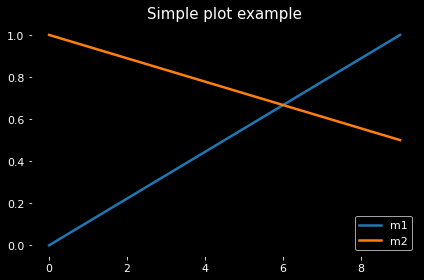

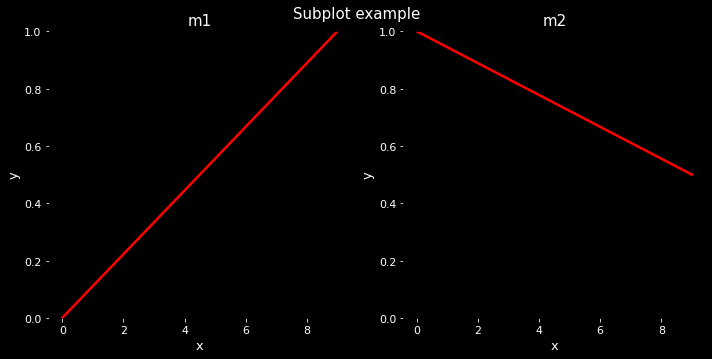

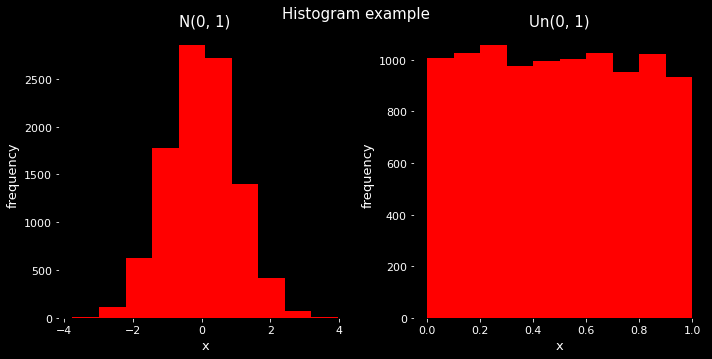

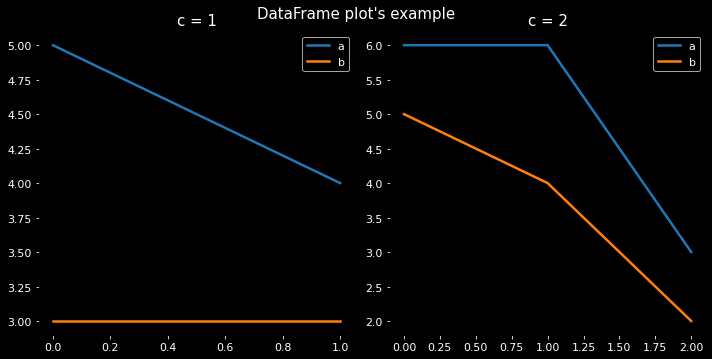

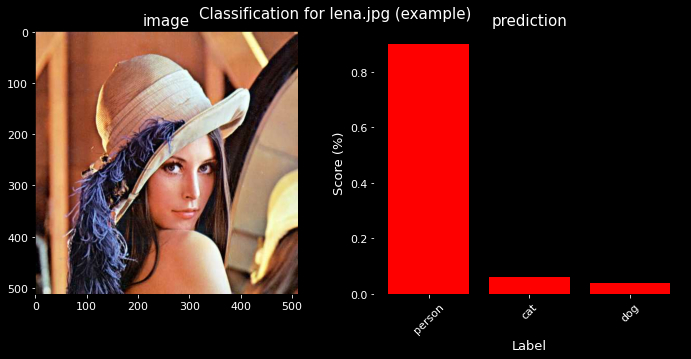

In [5]:
import numpy as np
import pandas as pd

from utils import plot, plot_multiple, load_json
from utils.image import load_image

datas = {
    'm1' : np.linspace(0, 1, 10),
    'm2' : np.linspace(1, 0.5, 10)
}
random_datas = {
    'N(0, 1)'  : np.random.normal(size = 10000),
    'Un(0, 1)' : np.random.uniform(size = 10000)
}

dataframe = pd.DataFrame([
    {'a' : 5, 'b' : 3, 'c' : 1},
    {'a' : 4, 'b' : 3, 'c' : 1},
    {'a' : 6, 'b' : 5, 'c' : 2},
    {'a' : 6, 'b' : 4, 'c' : 2},
    {'a' : 3, 'b' : 2, 'c' : 2},
])

_default_kwargs = {'use_subplots' : True, 'horizontal' : True, 'show' : True}

plot(datas, title = 'Simple plot example')
plot_multiple(
    ** datas, title = 'Subplot example', xlabel = 'x', ylabel = 'y', ylim = (0,1),
    ** _default_kwargs, filename = 'example_data/plots/plot_simple_example.png'
)
plot_multiple(
    ** random_datas, title = 'Histogram example', xlabel = 'x', ylabel = 'frequency',
    ** _default_kwargs, plot_type = 'hist', filename = 'example_data/plots/plot_hist_example.png'
)
plot_multiple(
    dataframe, by = 'c', title = "DataFrame plot's example",
    ** _default_kwargs, filename = 'example_data/plots/plot_dataframe_example.png'
)
plot_multiple(
    dataframe, corr = 'c', title = "DataFrame correlation plot's example",
    filename = 'example_data/plots/plot_dataframe_corr_example.png'
)
# the `plot_type = imshow` automatically sets `use_subplots = True` so you must put one of those 2 kwarg 
# otherwise it will plot both (image and bar plot) in the same subplot which is useless ;)
# Note that in real model's prediction, scores are not sorted and there are much more than 3 labels.
# In this case, it will show the `k` (default 5) best scores and sort them in decreasing order
plot_multiple(
    image = load_image('example_data/images/lena.jpg'), title = 'Classification for lena.jpg (example)',
    prediction = {'scores' : np.array([0.9, 0.06, 0.04]), 'labels' : ['person', 'cat', 'dog'], 'plot_type' : 'classification'},
    filename = 'example_data/plots/plot_image_classification.png', show = True, plot_type = 'imshow'
)

## Embeddings examples

Note : the provided embeddings are samples from the VoxForge dataset embedded by my `AudioSiamese` model : `audio_siamese_256_mel_lstm` (released in [this project](https://github.com/yui-mhcp/siamese_networks))

In this plot, each dot corresponds to an audio and the colors correspond to a specific speaker (its corresponding `id` is shown in the 1st plot's legend). 

It is normal that plots are different as the `embeddings` are vectors with 256 dimensions. To project them in the 2D space, I use by default the `UMAP` projection (with the `umap` library) which is based on randomness. 

Original embeddings :
                                              filename                                          embedding  \
0    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00011343794, -0.00012576704, 0.0004697689,...   
1    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00029487943, -0.00019367959, 0.0008462651,...   
2    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00012839596, -1.3334279e-05, 0.001058621, ...   
3    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00031986443, -0.00041395996, 0.000898958, ...   
4    VoxForge/fr/samuelbuffet-20090703-udq/wav/fr-s...  [-0.00027184433, -0.00063498016, 0.00038204438...   
..                                                 ...                                                ...   
595  VoxForge/fr/anonymous-20140418-dlc/wav/fr-sb-8...  [-0.00026001988, -0.00031830306, 0.0022616049,...   
596  VoxForge/fr/anonymous-20140418-dlc/wav/fr-sb-8...  [-0.00016911788, 2.0112968e-05, 0.0007426249, ... 

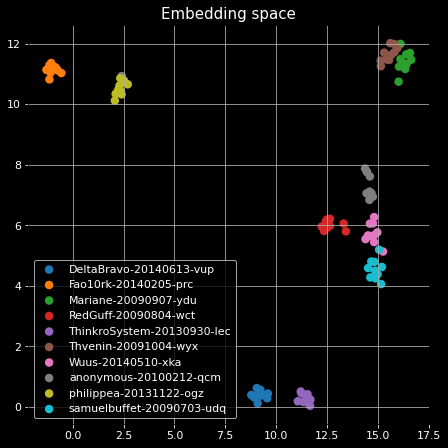

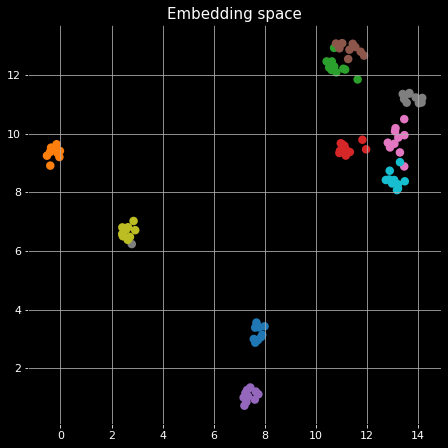

In [2]:
from utils import plot_embedding, set_display_options
from utils.embeddings import load_embedding
from utils.pandas_utils import sample_df, aggregate_df

set_display_options(rows = 10, width = 125)

directory = 'example_data'
filename = 'embeddings_{}_voxforge.csv'

embeddings = load_embedding(directory, embedding_dim = 256, embedding_name = filename)

print("Original embeddings :")
print(embeddings)

print("Count for each id")
print(aggregate_df(embeddings, 'id', 'filename', count = len))

samples = sample_df(embeddings) # get 10 embeddings for 10 different speakers

print("Samples to plot :")
print(samples)

plot_embedding(samples, filename = 'example_data/plots/plot_embeddings_with_legend.png')
# The legend is quite large and not really useful so you can remove it with the `with_legend` argument
plot_embedding(samples, filename = 'example_data/plots/plot_embeddings.png', with_legend = False)

## Logging example

### Timer usage

The `timer` function is a decorater tracking the function's performances. 

In the example below, `example_timed` is a decorated function calling 2 times `make_something_short` and 1 time `make_something_long` : 
- Each line (after `timers :`) is the performance of a specific timed function
- The indentation's level represents the call orders (which function are called inside another function). 
- If a function is called multiple times, it will log performances for all calls and compute the average time.

Note : `time.sleep` waits *at least* `t` seconds, it is the reason why the total time is larger than 2.8sec (the expected time) and it is **not** the `timer` that slows down that much the execution time ;)

Note 2 : the `timer` is now `thread-safe` meaning that you can run timed functions in multiple threads (useful to use it within the `producer-consumer` framework). It therefore tracks performances for each thread separately.

In [3]:
import time

from loggers import set_level, timer

@timer
def make_something_short(t):
    time.sleep(t / 5)
    
@timer
def make_something_long(t):
    time.sleep(t)

@timer
def example_timed(t):
    make_something_short(t)
    make_something_long(t)
    make_something_short(t)
    print("Hello world !")

set_level('time')

example_timed(2)

Hello world !
Timers for logger timer :
- example_timed : 2.819 sec
  - make_something_short executed 2 times : 0.818 sec (0.409 sec / exec)
  - make_something_long : 2.002 sec


### Telegram Logger

This logger allows to send all logs to your `Telegram` account (via the [Telegram Bot API](https://core.telegram.org/bots)).

1. Put your `Bot token` in the `TOKEN` variable
2. Send a regular message (not a command) to your bot to initialize `chat_id` (or put it manually as `kwargs`).

This logger can be useful when running codes on servers ! ;)

In [4]:
import logging

from loggers import set_level, add_handler

TOKEN = ''

set_level('info')

if TOKEN: add_handler('telegram', token = TOKEN)

logging.info('Hello World !')
logging.debug('This is a logging message (not sent)')

Hello World !


## `ThreadQueue` example

**Important** : I higly recommand you to use the `Consumer` class instead (check the `example_prod_cons`) as it better handles multi-threading. This class creates 1 thread / task (at most `max_workers` created at the same time) while the `Consumer` class creates `max_workers` threads and no more, which is much more efficient. 

This class is a `producer-consumer` implementation allowing **multi producer and multi consumer**. It also supports the 3 classical `queue` implementation : `LIFO Queue, FIFO Queue` and `Priority Queue`.

Arguments : 
- `target` : defines the *consumer* function.
- `mode` : the queue mode (lifo, fifo or priority).
- `max_workers` : defines the number of consumer to execute in parallel. If lower than 0, it will be executed in the queue's thread.
- `keep_result` : whether to keep `target`'s output or not. If yes, it will also keep the order of append (the 3rd append will produces the 3rd output even if it is executed after / before).

Some observations : 
- It is a `Priority Queue` : tasks are executing in the order of their priority (max or min first depending on the mode (max_priority vs min_priority))\*.
- The queue herits from `Thread` so it is executed in a different `Thread`. It is the reason why it can start executing tasks while you add new ones.
- Only 2 tasks are executed in parallel (`max_workers = 2`).
- The `wait_results` correcly returns data in the right order (range(5)) even tasks are executed in a different order.
- `wait_results` stops the queue and wait until all tasks are finished before returning results.

\* By design, the `queue.PriorityQueue` is a `min priority queue` (min priority first) so the trick to create a `max` priority queue is to give it `-priority`. It is the reason why you can see negative priorities in the debug messages. 

In [5]:
import time

from loggers import set_level
from utils import ThreadedQueue

set_level('debug') # allows to see when data are added / executed

def hello(name, t = 0.5):
    print("Start waiting for {}".format(t))
    time.sleep(t)
    print("Hello World {} !".format(name))
    return name

queue = ThreadedQueue(target = hello, mode = 'max_priority', max_workers = 3, keep_result = True)

queue.start()

for n in range(5):
    queue.append(n, priority = n, t = 5. / (n+1))

# queue.stop() # stops the queue, internally done by `wait_result`
print(queue.wait_result())

Start queue
Adding new data on the queue !
Try to get semaphore...
Adding new data on the queue !
Pop new data : Data(priority=0, index=0, data={'args': (0,), 'kwargs': {'t': 5.0}})
Adding new data on the queue !
Get a new task : Data(priority=0, index=0, data={'args': (0,), 'kwargs': {'t': 5.0}})
Adding new data on the queue !
start task 0 with priority 0
Start waiting for 5.0
Adding new data on the queue !
Try to get semaphore...
Pop new data : Data(priority=-4, index=4, data={'args': (4,), 'kwargs': {'t': 1.0}})
Get a new task : Data(priority=-4, index=4, data={'args': (4,), 'kwargs': {'t': 1.0}})
start task 4 with priority -4
Start waiting for 1.0
Try to get semaphore...
Pop new data : Data(priority=-3, index=3, data={'args': (3,), 'kwargs': {'t': 1.25}})
Get a new task : Data(priority=-3, index=3, data={'args': (3,), 'kwargs': {'t': 1.25}})
start task 3 with priority -3
Start waiting for 1.25
Try to get semaphore...
Hello World 4 !
finished task 4
Pop new data : Data(priority=-2, 

## Other examples

`load_json` and `dump_json` are utilities functions to load / save json data (while `{save / load}_data` are generic functions supporting multiple data types / file's formats).

They can be useful for 2 reasons : 
1. Make in 1 line a 3-line code :D
2. Avoid errors in loading / saving datas which can lead to a data destruction.

Indeed, if your json file is not well formatted, having a `JsonParserError` while loading the file can destroy the file. The 2 functions converts data to `json` format before / after saving / loading them to not have the error when the file is open.

In [6]:
from utils import load_data, load_json

filename = 'example_data/stft_config.json'
config = load_json(filename)
# load_data is a more general function that internally calls load_json as the extension is `.json`
print('Equivalent to load_data : {}'.format(config == load_data(filename)))
config

Equivalent to load_data : True


{'class_name': 'TacotronSTFT',
 'filter_length': 1024,
 'hop_length': 256,
 'win_length': 1024,
 'n_mel_channels': 80,
 'sampling_rate': 22050,
 'mel_fmin': 0.0,
 'mel_fmax': 8000.0,
 'normalize_mode': None,
 'pre_emph': 0.0,
 'window': 'hann',
 'to_magnitude': True,
 'periodic': True}